In [2]:
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
sns.set_theme(style="darkgrid")
import scipy.stats
from random import seed
from random import random
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
train=pd.read_csv('../out/Univariate_Wikipedia.csv')

In [4]:
train.head()

,Date,Average_Users
0,7/1/2015,1024.882127
1,7/2/2015,1031.233602
2,7/3/2015,973.123388
3,7/4/2015,1003.791022
4,7/5/2015,1044.341920


In [5]:
train["Date"] = pd.to_datetime(train["Date"], dayfirst=True)

In [6]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(train['Average_Users'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.4366326949128574
p-value: 0.1316628509144071


ADF statistics is not a large number and p-value is greater than 0.05. Apply transformation i.e. first order differencing.

In [7]:
average_users_diff=np.diff(train['Average_Users'], n=1)

In [8]:
ADF_result_diff = adfuller(average_users_diff)
print(f'ADF Statistic: {ADF_result_diff[0]}')
print(f'p-value: {ADF_result_diff[1]}')

ADF Statistic: -7.893704903918816
p-value: 4.367449072771518e-12


Now the series is stationary with a small p-value and ADF statistic is relatively larger(and negative) than the original series.

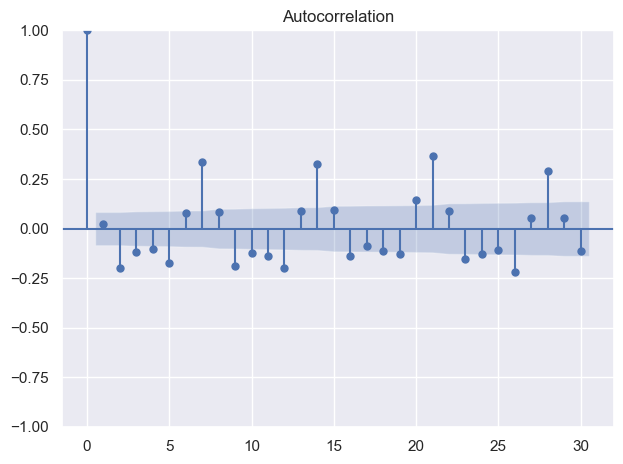

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(average_users_diff, lags=30);
plt.tight_layout()

This is not a moving avergae process because there are significant lags until lag 28.

Figure(640x480)


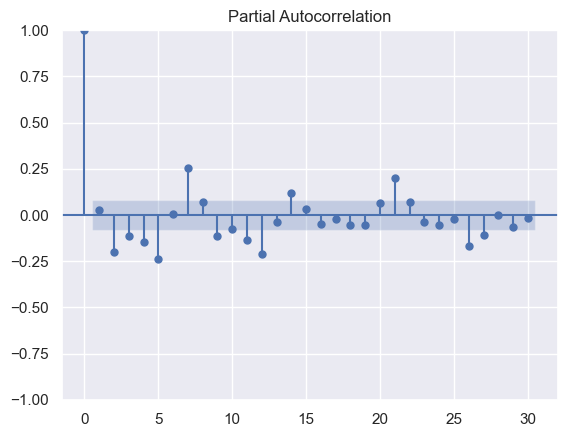

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
print(plot_pacf(average_users_diff, lags=30))

From the ACF plot we can see that the co-efficients do not diminish significantly. Same is true for PACF. Therefore its not a MA or AR series. The sinusoidal pattern demonstrates, we cannot infer anything from the ACF and PACF.

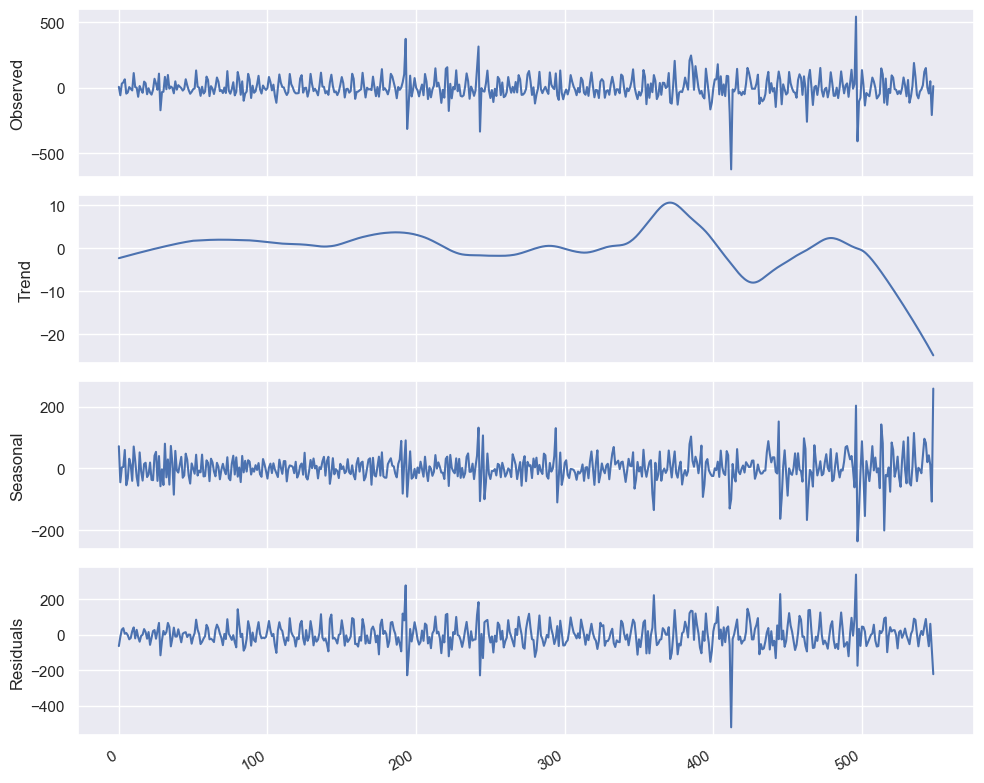

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
decomposition = STL(average_users_diff, period=52).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
#plt.xticks(np.arange(0, 128, 52))
fig.autofmt_xdate()
plt.tight_layout()

In [17]:
from itertools import product
ps = range(0, 7, 1)
qs = range(0, 7, 1)
Ps = [0]
Qs = [0]
d = 0
D = 0
s = 0
ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [18]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d:int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
            endog,
            order=(order[0], d, order[1]),
            seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [20]:
average_users_diff=pd.DataFrame(average_users_diff)

In [21]:
#Train test split
train_new = average_users_diff[:int(0.9*len(average_users_diff))]
test_new = average_users_diff[int(0.9*len(average_users_diff)):]

In [25]:
train_new=train_new.rename(columns={0:'Average_Users'})

In [27]:
train = train_new['Average_Users']
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/49 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(4, 6, 0, 0)",5531.556770
1,"(5, 6, 0, 0)",5532.313088
2,"(4, 4, 0, 0)",5533.323473
3,"(6, 4, 0, 0)",5534.186617
4,"(6, 5, 0, 0)",5543.323929
5,"(5, 4, 0, 0)",5546.152818
6,"(6, 2, 0, 0)",5576.277892
7,"(4, 3, 0, 0)",5579.557805
8,"(4, 2, 0, 0)",5581.947630
9,"(2, 6, 0, 0)",5584.637197


The best model is ARIMA (4,0,6) with the lowest AIC. Let us check the diagnostics to see if the assumptions are valid.

In [28]:
ARIMA_model = SARIMAX(train, order=(4,0,6), simple_differencing=True)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

Figure(1000x800)


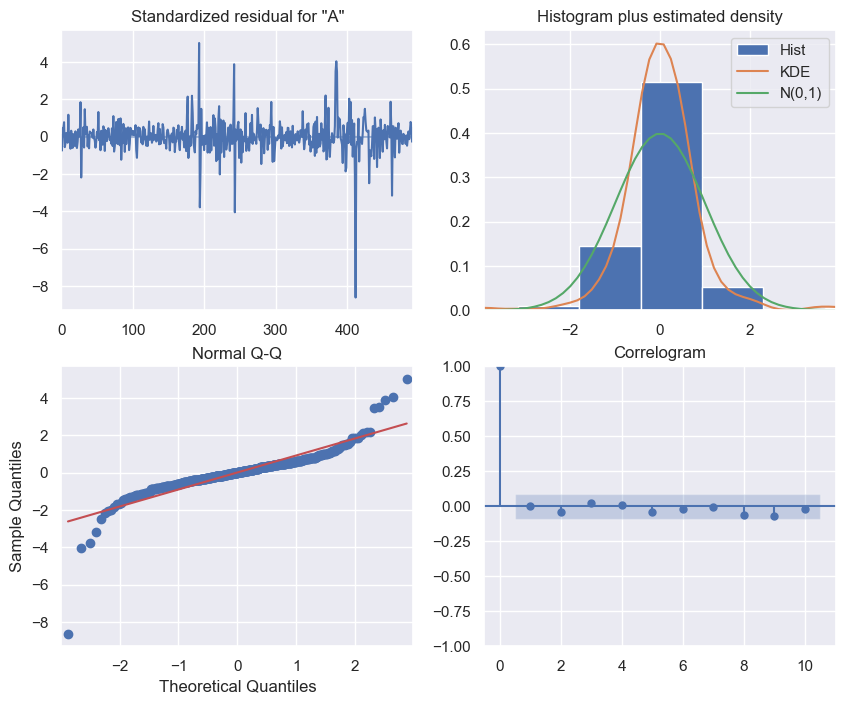

In [29]:
print(ARIMA_model_fit.plot_diagnostics(figsize=(10,8)))

Residuals diagnostics of the ARIMA(4,0,6) model. In the top-left plot, the residuals have no trend with a variance that seems fairly constant over time, which resembles the behavior of white noise. The top-right plot shows the distribution of the residuals, which approaches a normal distribution, despite the unusual peak. This is further confirmed by the Q-Q plot at the bottom left, which displays a fairly straight line that lies on y = x with a few exceptions on the tail. Finally, the correlogram in the bottom-right plot shows no significant autocorrelation coefficients after lag 0, which is exactly like white noise. From this analysis, the residuals resemble white noise.The next step is to run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated.


In [33]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = ARIMA_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals)
print(lbvalue, pvalue)

lb_stat lb_pvalue


In [35]:
test_new=test_new.rename(columns={0:'Average_Users'})

In [45]:
#test_new

In [37]:
ARIMA_pred = ARIMA_model_fit.get_prediction(494, 548).predicted_mean
test_new['ARIMA_pred'] = ARIMA_pred
test_new.head()

,Average_Users,ARIMA_pred
494,-7.956943,36.745354
495,27.792201,-66.509082
496,542.099570,-34.311048
497,-409.151810,-5.435397
498,-105.983448,-47.432502


In [38]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
train = train_new['Average_Users']
d = 0
D = 0
s = 52
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 0, 1)",5612.909153
1,"(1, 2, 1, 2)",5681.832108
2,"(1, 2, 1, 1)",5683.476481
3,"(1, 2, 2, 1)",5683.626872
4,"(2, 2, 1, 2)",5683.756093
...,...,...
76,"(0, 0, 0, 1)",5719.822970
77,"(1, 0, 1, 0)",5719.895933
78,"(1, 0, 0, 1)",5720.260584
79,"(1, 0, 0, 0)",5720.882024


Figure(1000x800)


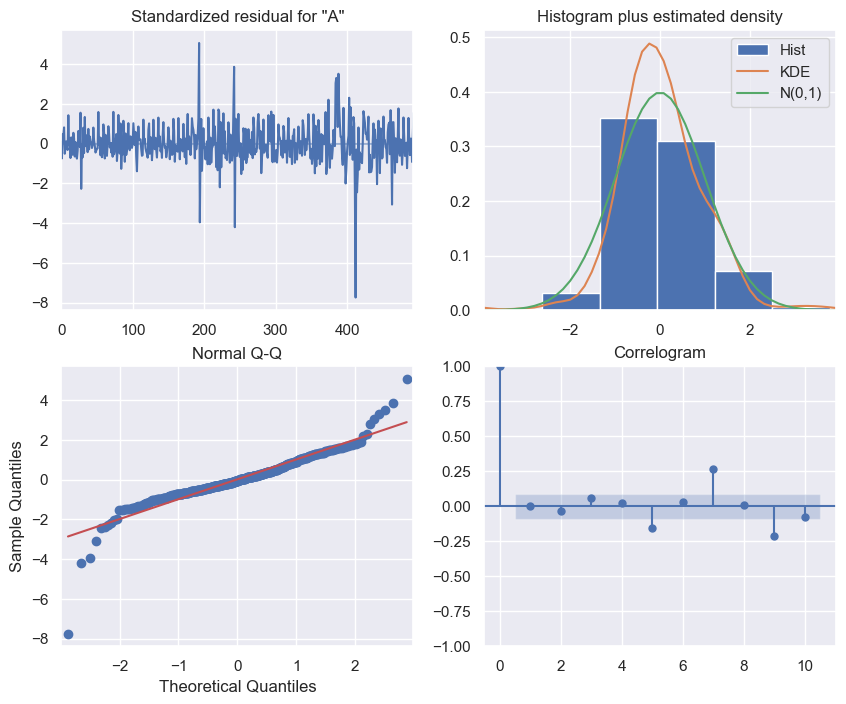

In [39]:
SARIMA_model = SARIMAX(train, order=(2,0,1), seasonal_order=(0,0,2,52),simple_differencing=True)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(SARIMA_model_fit.plot_diagnostics(figsize=(10,8)))

In [41]:
SARIMA_pred = SARIMA_model_fit.get_prediction(494, 548).predicted_mean
test_new['SARIMA_pred'] = SARIMA_pred
test_new

,Average_Users,ARIMA_pred,SARIMA_pred
494,-7.956943,36.745354,7.204816
495,27.792201,-66.509082,-31.344249
496,542.099570,-34.311048,-23.024645
497,-409.151810,-5.435397,-12.631346
498,-105.983448,-47.432502,-6.198553
499,-76.970482,8.378126,12.572842
500,134.036336,104.741374,5.004405
501,24.398413,39.558793,-3.093985
502,-135.909777,-65.286067,-12.986291
503,-40.629148,-34.478055,-8.984557


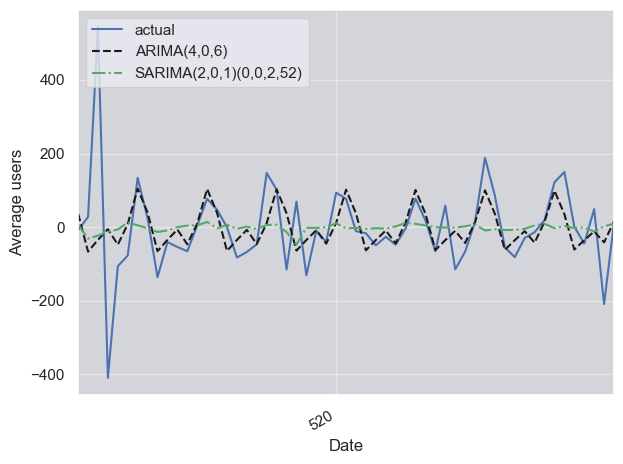

In [42]:
fig, ax = plt.subplots()
#ax.plot(df_overall['Date'], np.array(df_overall['Weekly_Sales']))

ax.plot(test_new['Average_Users'], 'b-', label='actual')
ax.plot(test_new['ARIMA_pred'], 'k--', label='ARIMA(4,0,6)')
ax.plot(test_new['SARIMA_pred'], 'g-.', label='SARIMA(2,0,1)(0,0,2,52)')
ax.set_xlabel('Date')
ax.set_ylabel('Average users')
ax.axvspan(494, 548, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 548, 52))
ax.set_xlim(494, 548)
fig.autofmt_xdate()
plt.tight_layout()

In [59]:
avg_users=np.r_[1348.671439,test_new['Average_Users']].cumsum()

In [60]:
arima=np.r_[1348.671439,test_new['ARIMA_pred']].cumsum()
sarima=np.r_[1348.671439,test_new['SARIMA_pred']].cumsum()

In [57]:
#arima[:5]

In [61]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_ARIMA = mape(avg_users, arima)
mape_SARIMA = mape(avg_users, sarima)
print('MAPE ARIMA',mape_ARIMA)
print('MAPE SARIMA',mape_SARIMA)

MAPE ARIMA 6.67933821240378
MAPE SARIMA 6.575494880259815


In [63]:
def mse(y_true, y_pred):
    return np.mean((y_pred-y_true)**2 )
mse_ARIMA = mse(avg_users, arima)
mse_SARIMA = mse(avg_users, sarima)
print('MSE ARIMA',mse_ARIMA)
print('MSE SARIMA',mse_SARIMA)

MSE ARIMA 15588.468797608328
MSE SARIMA 16575.65173498912
